# WMT of tendency terms
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Make histogram of each term](#first-bullet)
* [Save histograms](#second-bullet)

# 1) Make histogram of each term <a class='anchor' id='first-bullet'> </a>

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
from xhistogram.xarray import histogram
import pop_tools
import xesmf as xe

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [3]:
#Load in tendencies

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [4]:
tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tracer_tendencies_40yr.zarr'))
drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/drhodts_tendencies_40yr.zarr'))
rho_cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/rho_bih_cab_tendencies_40yr.zarr'))

tendencies = xr.merge([tracers, drhodts, rho_cab])

In [5]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 14965, nlat: 2400, nlon: 3600)
Coordinates:
  * nlat       (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon       (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

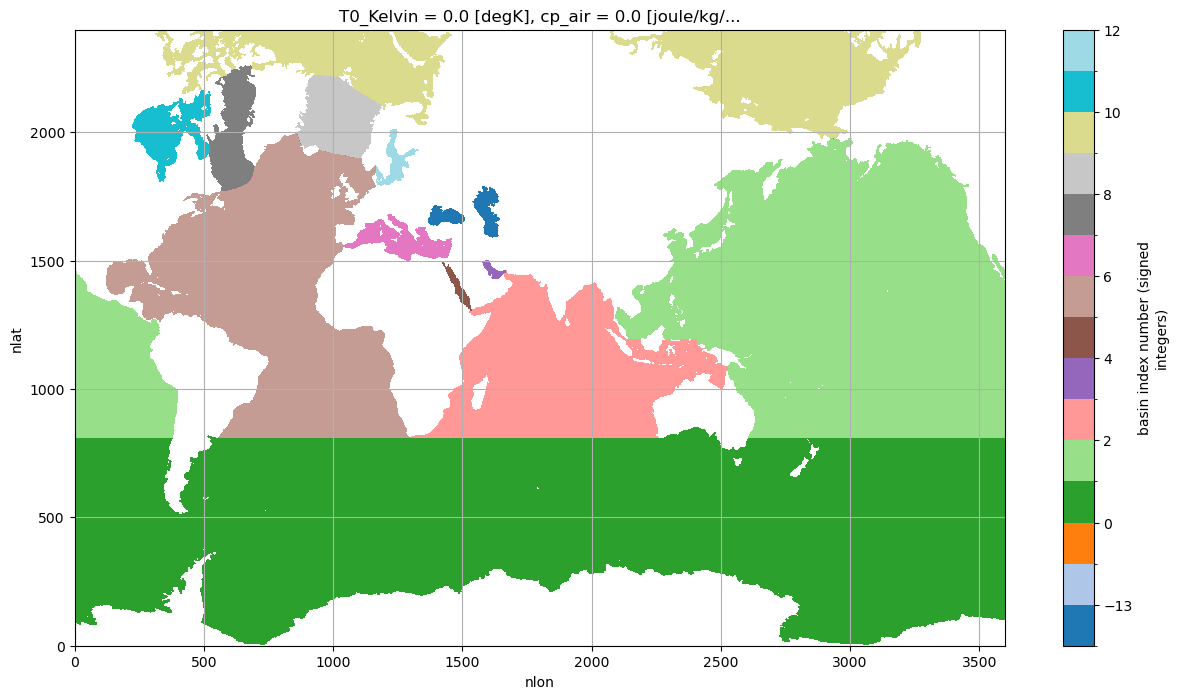

In [6]:
#to know which region index value is what basin
plt.figure(figsize=(15,8))
regions = np.unique(ds.REGION_MASK)
ds.REGION_MASK.where(ds.KMT>0).plot.contourf(levels=regions, cmap='tab20')
plt.grid();

In [35]:
regions

array([-14., -13.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
         8.,   9.,  10.,  11.,  12.])

In [20]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

In [7]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [8]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.2ede1130e2104301890cf7a4a400eddd/status,


In [51]:
client.close()
cluster.close()

# Split the tendencies by basin

In [23]:
all_tendencies = list(tendencies)

In [30]:
def basin_selection(tend_term, basin):
    tendency_in_basin = tend_term.where(ds.REGION_MASK==basin)
    return tendency_in_basin

In [35]:
#Atlantic Ocean
atl_ocean = xr.merge([basin_selection(tendencies[var], atlantic_ocean).rename('ATL' + var) for var in all_tendencies])

#Pacific Ocean
pac_ocean = xr.merge([basin_selection(tendencies[var], pacific_ocean).rename('PAC' + var) for var in all_tendencies])

#Indian Ocean
ind_ocean = xr.merge([basin_selection(tendencies[var], indian_ocean).rename('IND' + var) for var in all_tendencies])

#Arctic Ocean
arc_ocean = xr.merge([basin_selection(tendencies[var], arctic_ocean).rename('ARC' + var) for var in all_tendencies])

## Compute histogram by basin

In [17]:
rho = fastjmd95.rho(ds.SSS, ds.SST, 0)
#rho = rho_unsliced.isel(time=slice(0,182))

In [18]:
area = ds.TAREA * ds.dz * 1e-4 #convert cm^2 to m^2
delta_rho = 0.01
rho_bins = np.arange(1015, 1030, delta_rho)

In [19]:
tendency_terms = xr.merge([(tendencies.SST_bih*tendencies.drhodt).rename('sst'), 
                           (tendencies.SSS_bih*tendencies.drhods).rename('sss'), 
                            tendencies.rho_bih.rename('rho'), 
                            tendencies.cabbeling.rename('cabbeling')])

In [20]:
all_tendencies = list(tendency_terms)

In [21]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=(variable.fillna(0.)*ds.TAREA), dim=['nlon', 'nlat'])
    return hist / delta_rho

In [22]:
histograms = xr.merge([histogram_func(tendency_terms[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])

In [29]:
histograms

<xarray.Dataset>
Dimensions:          (time: 14965, rho0_bin: 1499)
Coordinates:
  * time             (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
Data variables:
    OMEGA_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_rho        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>

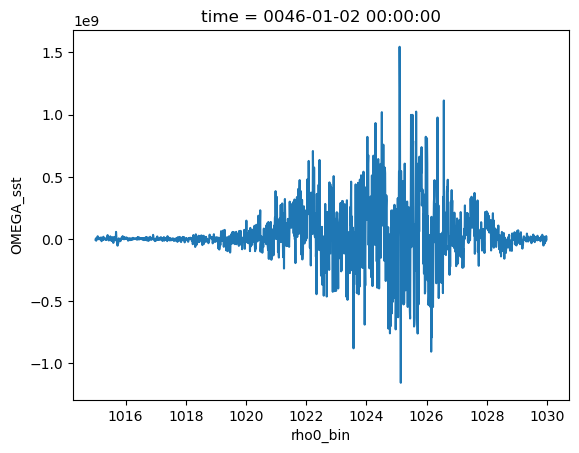

In [24]:
histograms.OMEGA_sst[0].plot()

In [28]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.1ac3d59b1bda4c7897fd3a5fd58cefcc/status,


# 2) Save histograms <a class='anchor' id='second-bullet'> </a>

In [ ]:
#saving monthly climatology histograms
gcsmap_hist = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/histograms.zarr')
histograms.to_zarr(gcsmap_hist, mode='w')

Task exception was never retrieved
future: <Task finished name='Task-825' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-826' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-827' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3

[Back to top](#top)